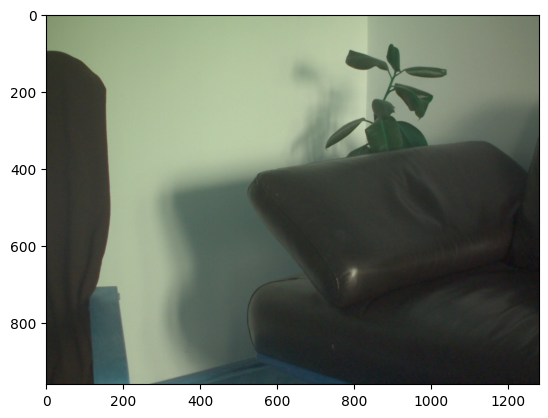

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from config import RED_WAVELENGTH, GREEN_WAVELENGTH, BLUE_WAVELENGTH, GAMMA
import cv2

#load test image
img = cv2.imread('image_test.png')
#show the png image
fig = plt.imshow(img)
plt.show()
#extract channels
red_channel = img[:,:,0]
green_channel = img[:,:,1]
blue_channel = img[:,:,2]
#display channels
# cv2.imshow('Red Channel', red_channel)
# cv2.imshow('Green Channel', green_channel)
# cv2.imshow('Blue Channel', blue_channel)
# cv2.waitKey(0)
# cv2.destroyAllWindows()




In [ ]:
#extract gamma metadata
from PIL import Image
import png

# Load the image
img = Image.open("image_test.png")

# Check for gamma info
info = img.info
if "gamma" in info:
    gamma = info["gamma"]
    print(f"Gamma (from PNG metadata): {gamma:.4f}")
elif "icc_profile" in info:
    print("ICC profile found; image may use complex color management.")
else:
    print("No gamma metadata found. Assuming sRGB (gamma ≈ 2.2)")


No gamma metadata found. Assuming sRGB (gamma ≈ 2.2)


In [ ]:
red_channel.shape


(960, 1280)

In [ ]:
red_channel

array([[123, 124, 121, ..., 111, 113, 105],
       [126, 128, 126, ..., 113, 114, 113],
       [125, 127, 127, ..., 110, 111, 111],
       ...,
       [ 39,  40,  37, ...,  26,  26,  25],
       [ 39,  39,  35, ...,  25,  27,  27],
       [ 38,  39,  34, ...,  26,  27,  27]],
      shape=(960, 1280), dtype=uint8)

### No gamma correction

In [3]:
# c-matrix (of the book)
c_mx = np.zeros(red_channel.shape + (2,))
c_mx[:,:,0] = np.log(red_channel) - np.log(blue_channel)
c_mx[:,:,1] = np.log(green_channel) - np.log(blue_channel)

C:\Users\feher\AppData\Local\Temp\ipykernel_39492\4037570095.py:3: RuntimeWarning: divide by zero encountered in log
  c_mx[:,:,0] = np.log(red_channel) - np.log(blue_channel)
C:\Users\feher\AppData\Local\Temp\ipykernel_39492\4037570095.py:4: RuntimeWarning: divide by zero encountered in log
  c_mx[:,:,1] = np.log(green_channel) - np.log(blue_channel)


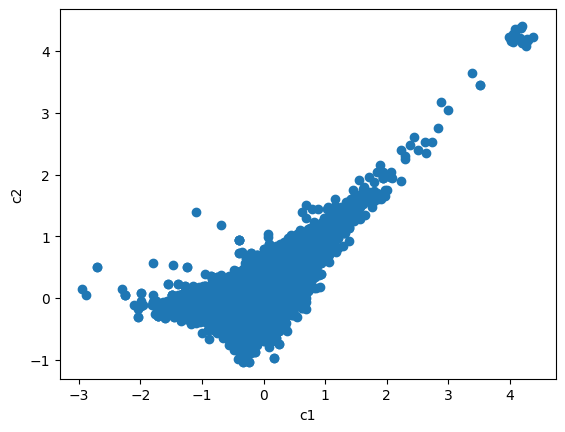

In [4]:
#scatterplot 
plt.scatter(c_mx[:,:,0].flatten(), c_mx[:,:,1].flatten())
plt.xlabel('c1')
plt.ylabel('c2')
plt.show()

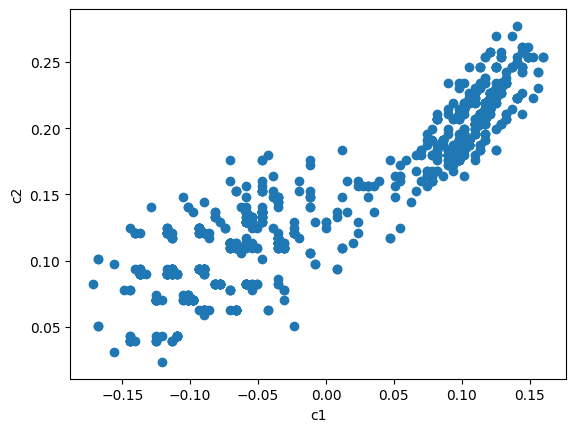

In [5]:
# probe a line, with white wall, and white wall and shadow
plt.scatter(c_mx[0:900,400,0].flatten(), c_mx[0:900,400,1].flatten())
plt.xlabel('c1')
plt.ylabel('c2')
plt.show()

### Gamma correction (with gamma = 2.2)

In [42]:
# c-matrix (of the book)
c_mx = np.zeros(red_channel.shape + (2,))
c_mx[:,:,0] = np.log((red_channel/255)**GAMMA) - np.log((blue_channel/255)**GAMMA)
c_mx[:,:,1] = np.log((green_channel/355)**GAMMA) - np.log((blue_channel/255)**GAMMA)

C:\Users\feher\AppData\Local\Temp\ipykernel_39492\3825405652.py:3: RuntimeWarning: divide by zero encountered in log
  c_mx[:,:,0] = np.log((red_channel/255)**GAMMA) - np.log((blue_channel/255)**GAMMA)
C:\Users\feher\AppData\Local\Temp\ipykernel_39492\3825405652.py:4: RuntimeWarning: divide by zero encountered in log
  c_mx[:,:,1] = np.log((green_channel/355)**GAMMA) - np.log((blue_channel/255)**GAMMA)


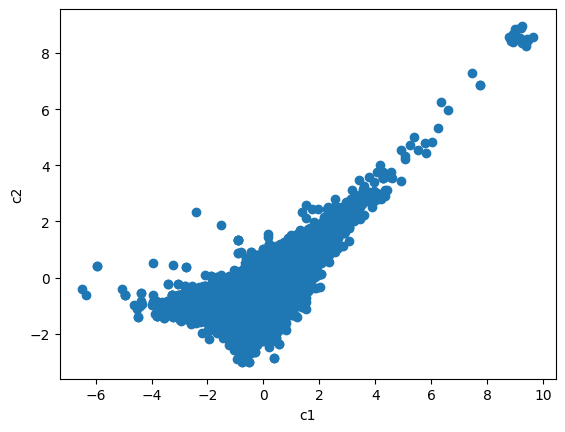

In [7]:
#scatterplot 
plt.scatter(c_mx[:,:,0].flatten(), c_mx[:,:,1].flatten())
plt.xlabel('c1')
plt.ylabel('c2')
plt.show()

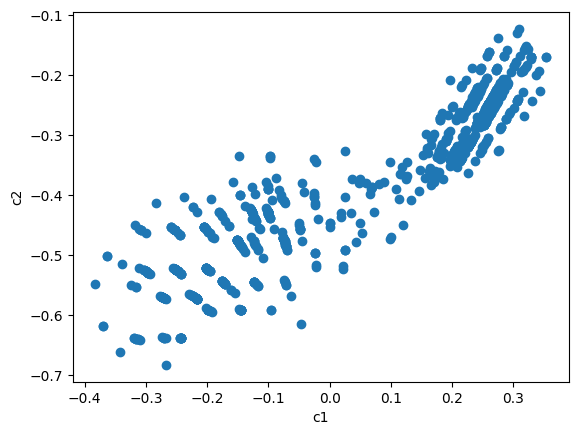

In [8]:
# probe a line, with white wall, and white wall and shadow
plt.scatter(c_mx[0:900,400,0].flatten(), c_mx[0:900,400,1].flatten())
plt.xlabel('c1')
plt.ylabel('c2')
plt.show()

### Finding the invariant image

In [60]:
#approximate value of color temperature direction
print(1/BLUE_WAVELENGTH - 1/RED_WAVELENGTH,1/BLUE_WAVELENGTH - 1/GREEN_WAVELENGTH)
np.arctan((1/BLUE_WAVELENGTH - 1/GREEN_WAVELENGTH)/(1/BLUE_WAVELENGTH - 1/RED_WAVELENGTH))/np.pi*180

0.0005276595744680851 0.00030947775628626696


np.float64(30.392060568943737)

In [54]:
# project perpendicular to the color temperature direction
def projection(c_mx, color_temp_direction):
    '''todo: include restrictions on inputs'''
    #rotate the color temperature direction by 90 degrees
    tangent_direction = np.array([color_temp_direction[1], -color_temp_direction[0]])
    tangent_direction = tangent_direction / np.linalg.norm(tangent_direction)
    #project c_mx onto tangent_direction
    c_mx_flatten = c_mx.reshape(-1,2)
    projection = c_mx_flatten @ tangent_direction
    return projection

def histogram_entropy(data, bins='auto'):
    # Compute histogram (counts, not densities)
    counts, _ = np.histogram(data, bins=bins)
    
    # Normalize to get probabilities
    probs = counts / counts.sum()

    # Filter out zero entries to avoid log(0)
    probs = probs[probs > 0]

    # Compute entropy (base 2 for bits, or natural log for nats)
    return entropy(probs, base=2)  # or base=np.e for nats

In [ ]:
#test
projection(np.array([[[1,2],[3,4],[5,6]],[[7,8],[9,10],[11,12]]]), np.array([1,-1]))
np.array([9,10]) @ np.array([-1/np.sqrt(2),-1/np.sqrt(2)])

[-0.70710678 -0.70710678]


array([ -2.12132034,  -4.94974747,  -7.77817459, -10.60660172,
       -13.43502884, -16.26345597])

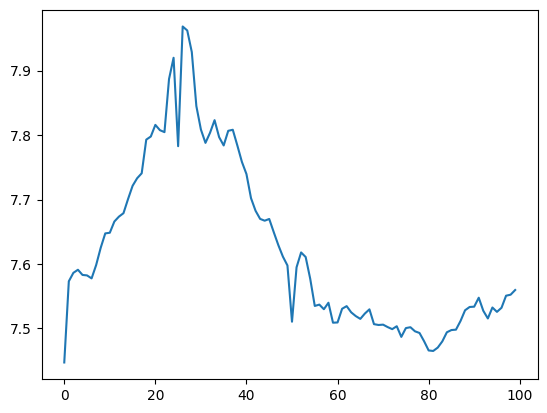

In [ ]:
i_max = 100
entropy_list = [] 
for i in range(i_max):
    norm_dir = np.array([np.cos(i*1/i_max*np.pi),np.sin(i*1/i_max*np.pi)])
    invariant_image = projection(c_mx, norm_dir)
    invariant_image_clean = invariant_image[~np.isnan(invariant_image)] #removes nan
    invariant_image_clean = invariant_image[np.isfinite(invariant_image)] #removes inf, -inf
    entropy_list.append(histogram_entropy(invariant_image_clean))
    #print(histogram_entropy(invariant_image_clean))
    #print(invariant_image)
   

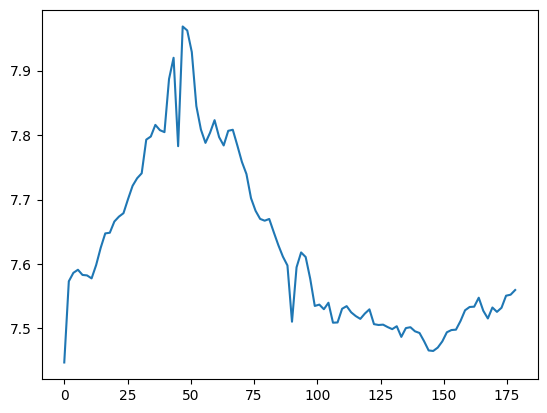

In [62]:
plt.plot([i*1/i_max*180 for i in range(i_max)],entropy_list)

In [48]:
i=1
norm_dir = np.array([np.cos(i*0.1*np.pi),np.sin(i*0.1*np.pi)])
invariant_image = projection(c_mx, norm_dir)
invariant_image_clean = invariant_image[~np.isnan(invariant_image)]
print(histogram_entropy(invariant_image_clean))

[ 0.30901699 -0.95105652]
7.648503755116511


In [ ]:
np.array

0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


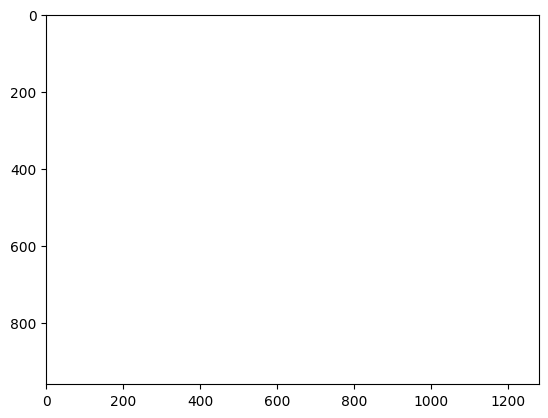

In [ ]:
#plot only the probed line

empty_image = np.ones(img.shape) * int(255)
#empty_image[0:900,400,:]  = img[0:900,400,:]

fig = plt.imshow(empty_image)
plt.show()